# Assignment 2: Speech Production and Models
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 38

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward gain and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [12]:
import numpy as np
import pickle as pkl
import sounddevice as sd

In [16]:
def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)
# print(data,'check what is inside d')   # dict type
print(data["speech8"],'check speech8' '\n', data["speech8"].shape, 'shape of speech8')

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

play_wav(data['speech8'],8000)      # check speech8

[[  1.60155162]
 [  2.62439824]
 [  1.43115507]
 ...
 [-19.6068527 ]
 [ -0.22280581]
 [  0.41062539]] check speech8
 (46030, 1) shape of speech8


### Question 1

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """

    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


In [17]:
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    L = 2**n_bits
    offset = m-xmax
    delta = (2*xmax)/L
    n = len(xin)
    idx = np.zeros((n))   # check shape
    # print(idx.shape,'idx matrix shape')
    for i in range(n-1):   # for each sample
        d = xin[i] - offset
        if d < delta:
            idx[i] = 0
        elif d >= (L-1)*delta:
            idx[i] = L-1
        else:
            idx[i] = np.floor(d/delta)

    return idx

x = np.linspace(-6,6,1201)
idx_test = sq_enc(x, 2, 4, 0)



def sq_dec(idx, n_bits, xmax, m):
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    L = 2**n_bits
    delta = 2*xmax/L
    offset = m - xmax
    outq = offset+(2*idx+1)*(delta/2)
    return outq

### Question 2 (4 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$.

Plot the quantizer output as a function of the input.

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

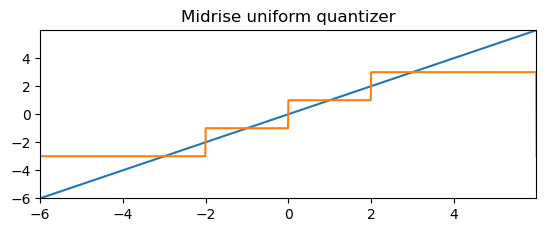

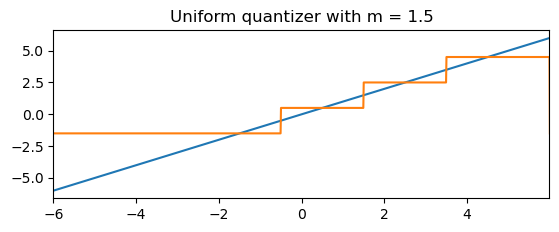

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-6,6,1201)
n_bits = 2
xmax = 4
m1 = 0
m2 = 1.5
idx1 = sq_enc(x,n_bits,xmax,m1)
outq1 = sq_dec(idx1,n_bits,xmax,m1)
idx2 = sq_enc(x,n_bits,xmax,m2)
outq2 = sq_dec(idx2,n_bits,xmax,m2)

plt.figure()
plt.subplot(211)
plt.plot(x,x)
plt.plot(x,outq1)
plt.xlim(-6,5.99)
plt.ylim(-6,5.99)
plt.title('Midrise uniform quantizer')
plt.show()

plt.figure()
plt.subplot(212)
plt.plot(x,x)
plt.xlim(-6,5.99)
plt.plot(x,outq2)
plt.title('Uniform quantizer with m = 1.5')
plt.show()


## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your own vocoder.
However, it must produce a quality that is at least as high as our vocoder provided to you.
If not, then you have to get aquainted with our vocoder, and use that in the following.
In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example).
This is acceptable also here.

In [19]:
from scipy import signal
from scipy.linalg import solve_toeplitz, toeplitz

def xcorr(x,y,M=10):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation             # Returns an array containing cross-correlation lag/displacement indices.
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]   # truncate，len(lags) = 21, corr(only remain last 11 values)

In [20]:
# introduce the analysis filter from the previous project
def analysis4(x, alen, ulen, M):
    # Initialization
    N = len(x)
    naf = (N-alen+ulen) // ulen       # Number of analysis frames
    n1 = 0
    threshold = 0.3
    E = np.zeros((naf, 1))
    ZC = []
    V = []
    A = np.zeros((naf, M+1)) # M is the prediction order.
    # M+1 allows space for the leading 1
    P = []
    # Inside loop
    for n in range(naf):

        n1 = n*ulen
        xf4 = x[n1:n1+alen, 0]
        # n1 = n1 + ulen

        for i in range(alen):
            E[n, 0] = E[n, 0] + xf4[i]**2
        E[n, 0] = E[n, 0] / alen

        n_zero = 0
        xf_find_zero = xf4.tolist()
        zero_decider = [xf_find_zero[j] * xf_find_zero[j-1] for j in range(1,alen)]
        for num in zero_decider:
            if num < 0:
                n_zero += 1

        ZC.append(n_zero/alen)     # The normalized number of zero crossings

        if n_zero/alen < threshold:
            V.append(1)           # voiced
        else:
            V.append(0)           # unvoiced

        xf4 = xf4.astype(np.float32)
        lags1, r = xcorr(xf4, xf4, M=M)  # autocorrelation  faixx

        A[n,:] = np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).ravel()
        # design the searching algorithm
        d = signal.correlate(xf4, xf4,'full')
        # autocorrection function  511 (256+256-1)
        d = d[alen-1:]    # truncate 256
        # if n == 0 or n == 29:
        #     plt.figure()
        #     plt.plot(np.arange(0,256,1),d)
        #     plt.title('autocorrelation shape')
        #     plt.xlabel('index')
        #     plt.ylabel('ACF')
        #     plt.ylim(np.min(d),np.max(d))
        #     plt.show()

        peak_index = []
        peak_value = []
        d_find = list(d)
        for i in range(len(d_find)):
            if i != len(d_find)-1:
                if d_find[i]>d_find[i-1] and d_find[i]>d_find[i+1]:   # denote peak
                    peak_index.append(i)
                    peak_value.append(d[i])
        peak_index = peak_index[1:]
        peak_value = peak_value[1:]
        # if n == 0 or n == 29:
        #     print('slide number: ', n)
        #     print('peak index: ', peak_index)
        #     print('peak value: ', peak_value)
        #     print('max peak index: ', peak_index[peak_value.index(max(peak_value))])
        max_peak_idx = peak_index[peak_value.index(max(peak_value))]

        # print(max(peak_value))
        # print(max_peak_idx)
        P.append(max_peak_idx)    # Pitch period in samples

    ZC = np.array(ZC)
    V = np.array(V)
    return E, ZC, V, A, P

In [21]:
def synthesis4(E, ZC, V, A, P, ulen):
    n_frames = A.shape[0]  # 586, Assuming filter coefficients are stored row-wise
    # Create a pulse train excitation:
    cp = 80  # Constant pitch period in samples
    # Create noise excitation:
    nexc = np.random.random(n_frames * ulen)
    n1 = 0
    Z = np.array([])
    s = np.zeros((n_frames * ulen))

    for n in range(0, n_frames):
        # Filter the excitation through the production (vocal tract) filter:
        # Low pass filter
        pexc, cp = np.zeros((n_frames * ulen)), P[n]
        pexc[0::cp] = 1
        exc = pexc if V[n] == 1 else nexc
        if Z.shape[0] == 0:  # 1st iteration
            s[n1:n1 + ulen] = signal.lfilter(np.array([1]), A[n, :], exc[n1:n1 + ulen])
            Z = signal.lfiltic(np.array([1]), A[n, :], s[n1:n1 + ulen], x=exc[n1:n1 + ulen])
        else:
            s[n1:n1 + ulen], Z = signal.lfilter(np.array([1]), A[n, :], exc[n1:n1 + ulen], zi=Z)
        energy_sum = sum([e ** 2 for e in s[n1:n1 + ulen]]) / ulen
        for i in range(ulen):
            # print(E[n, 0])
            s[n1 + i] = s[n1 + i] * ((E[n, 0] / energy_sum) ** 0.5)

        n1 += ulen
    return s

### Quantizing the Gain (8 pts)

#### Question 1 (1 pts)

Provide a plot of the histogram of the gain parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

[[5.65752838e+00]
 [5.46017762e+00]
 [4.47775052e+00]
 [4.20409905e+00]
 [1.49955466e+01]
 [2.68547998e+01]
 [5.04265199e+01]
 [9.68115498e+01]
 [1.55821141e+02]
 [2.00791383e+02]
 [2.34169647e+02]
 [3.35144111e+02]
 [4.31247724e+02]
 [9.74626491e+02]
 [1.35997786e+03]
 [1.56353624e+03]
 [2.18291704e+03]
 [2.70770979e+03]
 [3.46125644e+03]
 [5.38002083e+03]
 [5.07907489e+03]
 [2.25470786e+03]
 [2.22337046e+02]
 [1.02197043e+02]
 [2.81318236e+02]
 [7.77364160e+02]
 [1.35962174e+03]
 [8.21141351e+02]
 [5.21658852e+01]
 [2.44224078e+01]
 [1.13027372e+03]
 [2.56829829e+03]
 [3.47780902e+03]
 [3.23682164e+03]
 [3.19267185e+03]
 [3.06801267e+03]
 [2.10126281e+03]
 [6.42405619e+02]
 [1.11631396e+02]
 [1.79827464e+02]
 [7.93451847e+01]
 [9.72305851e+01]
 [1.27517192e+02]
 [9.25837910e+01]
 [7.97702036e+01]
 [1.17583373e+02]
 [1.02715816e+03]
 [1.71520720e+03]
 [1.69011788e+03]
 [1.63625125e+03]
 [1.49637799e+03]
 [1.02307118e+03]
 [7.89128368e+01]
 [2.49089706e+02]
 [2.74095603e+02]
 [8.331133

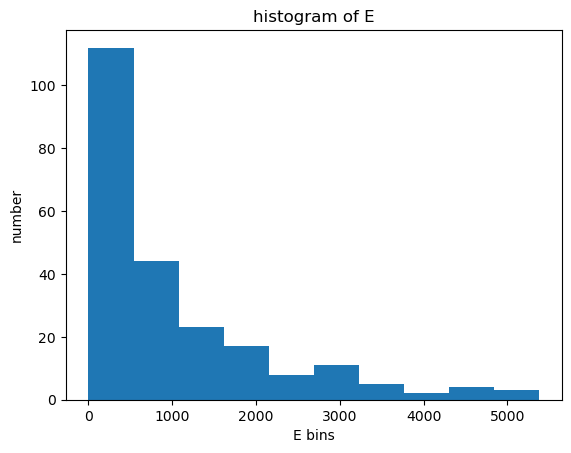

In [65]:
input_sig = data["speech8"]

alen = 256
ulen = 200
M = 10
[E, ZC, V, A, P] = analysis4(input_sig, alen, ulen, M)
plt.figure()
plt.hist(np.sqrt(E))            # the energy is displayed in sqrt
# plt.hist(E)
plt.xlabel("E bins")
plt.ylabel("number")
plt.title("histogram of E")
plt.show()


#### Question 2 (2 pts)

Run the vocoder with a uniform scalar gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

###### nbits_op = 6    # increase from 2 to 10, 6 is the threshold in which speech become smooth and cannot hear quantization distortion

[[5.65752838e+00]
 [5.46017762e+00]
 [4.47775052e+00]
 [4.20409905e+00]
 [1.49955466e+01]
 [2.68547998e+01]
 [5.04265199e+01]
 [9.68115498e+01]
 [1.55821141e+02]
 [2.00791383e+02]
 [2.34169647e+02]
 [3.35144111e+02]
 [4.31247724e+02]
 [9.74626491e+02]
 [1.35997786e+03]
 [1.56353624e+03]
 [2.18291704e+03]
 [2.70770979e+03]
 [3.46125644e+03]
 [5.38002083e+03]
 [5.07907489e+03]
 [2.25470786e+03]
 [2.22337046e+02]
 [1.02197043e+02]
 [2.81318236e+02]
 [7.77364160e+02]
 [1.35962174e+03]
 [8.21141351e+02]
 [5.21658852e+01]
 [2.44224078e+01]
 [1.13027372e+03]
 [2.56829829e+03]
 [3.47780902e+03]
 [3.23682164e+03]
 [3.19267185e+03]
 [3.06801267e+03]
 [2.10126281e+03]
 [6.42405619e+02]
 [1.11631396e+02]
 [1.79827464e+02]
 [7.93451847e+01]
 [9.72305851e+01]
 [1.27517192e+02]
 [9.25837910e+01]
 [7.97702036e+01]
 [1.17583373e+02]
 [1.02715816e+03]
 [1.71520720e+03]
 [1.69011788e+03]
 [1.63625125e+03]
 [1.49637799e+03]
 [1.02307118e+03]
 [7.89128368e+01]
 [2.49089706e+02]
 [2.74095603e+02]
 [8.331133

C:\Users\Chenting Zhang\AppData\Local\Temp\ipykernel_19100\2040901919.py:19: RuntimeWarning: invalid value encountered in sqrt
  plt.xlim(0,len(np.sqrt(outq_E_opt[:,0])))


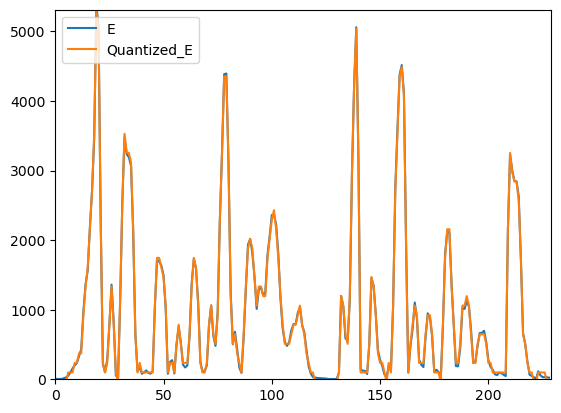

C:\Users\Chenting Zhang\AppData\Local\Temp\ipykernel_19100\2604449416.py:25: RuntimeWarning: invalid value encountered in double_scalars
  s[n1 + i] = s[n1 + i] * ((E[n, 0] / energy_sum) ** 0.5)


In [107]:
nbits_op = 6    # increase from 2 to 10, 6 is the threshold
# idx_E1 = sq_enc(E,n_bits,xmax_E,mean_E)   # quantize E with 2bits
# outq_E1 = sq_dec(idx_E1, n_bits, xmax_E,mean_E)
mean_E = np.mean(np.sqrt(E))
xmax_E = np.max(np.sqrt(E)) - mean_E
print(np.sqrt(E), 'shape of E')
print(np.sqrt(mean_E),'mean','\n', np.sqrt(xmax_E),'xmax')
idx_E_opt= sq_enc(np.sqrt(E),nbits_op,xmax_E,mean_E)   # quantize E with 6bits
outq_E_opt = np.expand_dims(sq_dec(idx_E_opt, nbits_op, xmax_E,mean_E),axis=1)
# expand dims so as to have the same dimension with E

print(np.sqrt(E[100,0]))
print(outq_E_opt[100,0])

plt.figure()
line1, = plt.plot(np.sqrt(E[:,0]))
line2, = plt.plot(outq_E_opt[:,0])
plt.legend([line1, line2], ["E", "Quantized_E"], loc='upper left')
plt.xlim(0,len(np.sqrt(outq_E_opt[:,0])))
plt.ylim(0,np.max(outq_E_opt))
plt.show()

# play the reconstructed speech
output_E_original = synthesis4(E, ZC, V, A, P, ulen)
output_sig = synthesis4(outq_E_opt, ZC, V, A, P, ulen)

fs = 8000
# play_wav(input_sig,fs)   # original speech
# play_wav(output_E_original, fs)
play_wav(output_sig, fs)

#### Question 3 (1 pts)

Take the logarithm of the gain parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the gain parameter in the log-domain.
Indicate the range of this quantizer as above.

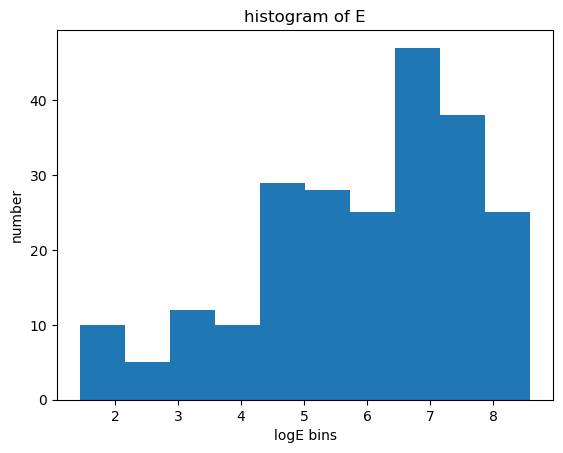

In [114]:
input_sig = data["speech8"]

alen = 256
ulen = 200
M = 10
[E, ZC, V, A, P] = analysis4(input_sig, alen, ulen, M)
E_log = np.log(np.sqrt(E))     # log domain

plt.figure()
plt.hist(E_log)
plt.xlabel("logE bins")
plt.ylabel("number")
plt.title("histogram of E")
plt.show()


#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-gain).

7.766550943404724
7.591621783157136


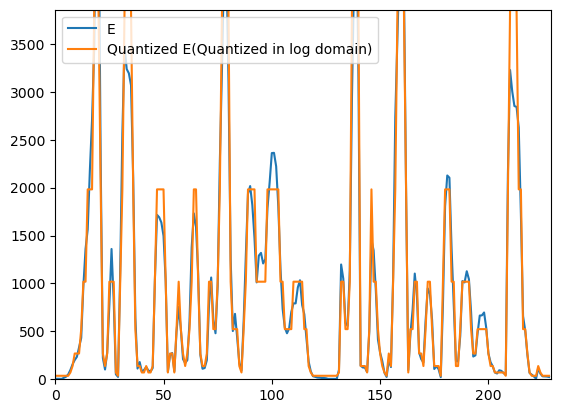

In [117]:
nbits_op = 4    # increase from 2 to 10, 4 is the rough threshold

mean_logE = np.mean(E_log)
xmax_logE = np.max(E_log) - mean_logE

idx_logE_opt= sq_enc(E_log,nbits_op,xmax_logE,mean_logE)   # quantize E with 6bits
outq_logE_opt = np.expand_dims(sq_dec(idx_logE_opt, nbits_op, xmax_logE, mean_logE),axis=1)
# expand dims so as to have the same dimension with E

print(E_log[100,0])
print(outq_logE_opt[100,0])

plt.figure()
line3, = plt.plot(np.sqrt(E[:,0]))
line4, = plt.plot(np.exp(outq_logE_opt))
plt.legend([line3, line4], ["E", "Quantized E(Quantized in log domain)"], loc='upper left')
plt.xlim(0,len(np.exp(outq_logE_opt[:,0])))
plt.ylim(0,np.max(np.exp(outq_logE_opt)))
plt.show()

# To hear the quantization error
output_E_original = synthesis4(E, ZC, V, A, P, ulen)
output_sig = synthesis4(np.exp(outq_logE_opt), ZC, V, A, P, ulen)

fs = 8000
# play_wav(input_sig,fs)   # original speech
# play_wav(output_E_original, fs)
play_wav(output_sig, fs)

#### Question 5 (2 pts)

Which is better: gain quantization in linear or log domain?

###### Answer:
Gain quantization in log domain is better, since it needs fewer quantization bits to obtain the same effect. In other words, with bits the same, it can generate better reconstructed speech with less quantization error